In [158]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Load Data and Split Training and Testing

In [160]:
# Tickers and Features
tickers = ['AAPL', 'AMZN', 'BA', 'COST', 'JNJ', 'NVDA', 'TMO', 'TSLA', 'VLO']
data_dir = "/Data"
features = ['close', 'volume', 'log_return', 'ann_return_1w', 'ann_return_2w', 'ann_return_1m', 'rolling_vol_7d', 'macd_1w_1m', 'news_count', 'mean_sentiment', 'sentiment_variance', "product"]



# Load data
all_data = {}
min_length = float('inf')


for stock in tickers:
    df = pd.read_csv(os.path.join(data_dir, f"{stock}_with_sentiment_features_with_product.csv"))
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['date'] = pd.to_datetime(df['date'])
    df[['news_count', 'mean_sentiment', 'sentiment_variance', 'normalized_news_frequency', "product"]] = df[
            ['news_count', 'mean_sentiment', 'sentiment_variance', 'normalized_news_frequency', "product"]
        ].fillna(0)
    df = df.dropna().reset_index(drop=True)

    all_data[stock] = df
    min_length = min(min_length, len(df)) 

for stock in tickers:
    all_data[stock] = all_data[stock].tail(min_length).reset_index(drop=True)

#Align date
dates = all_data[tickers[0]]['date'].values
total_len = len(dates)

# Train-Test split
test_size = 0.3
split_idx = int(total_len * (1 - test_size))
train_dates = dates[:split_idx]
test_dates = dates[split_idx:]

print(f"Train: {train_dates[0]}~{train_dates[-1]}")
print(f"Test: {test_dates[0]}~{test_dates[-1]}")

Train: 2021-02-03T00:00:00.000000000~2024-02-09T00:00:00.000000000
Test: 2024-02-12T00:00:00.000000000~2025-05-30T00:00:00.000000000


# Perform PCA on Features
Use first 6 components as input features

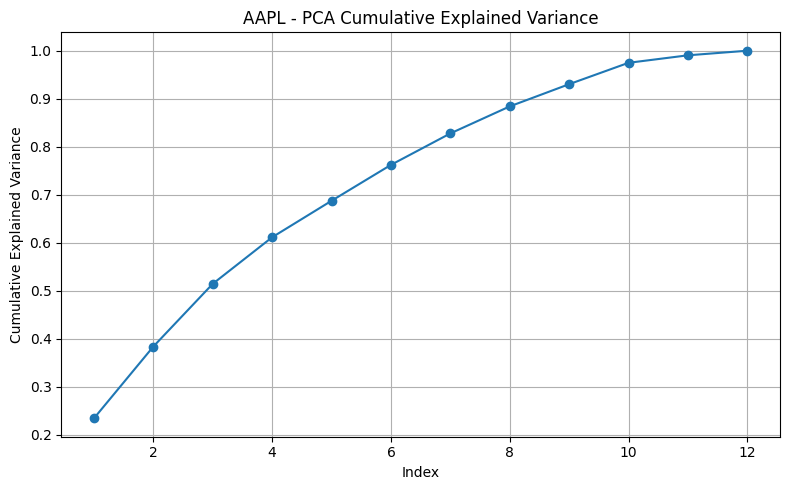

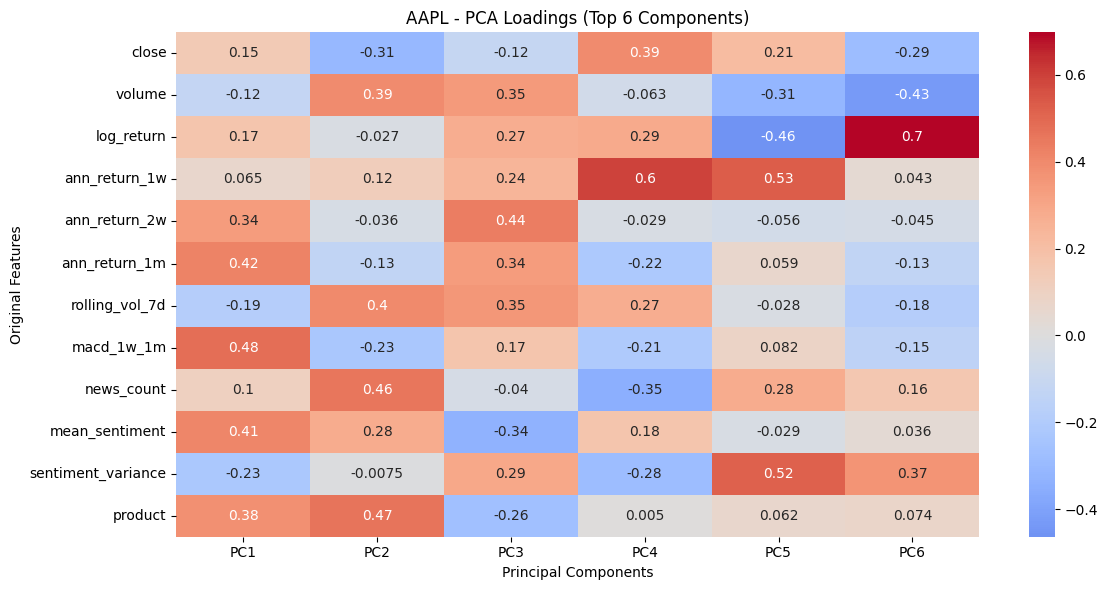

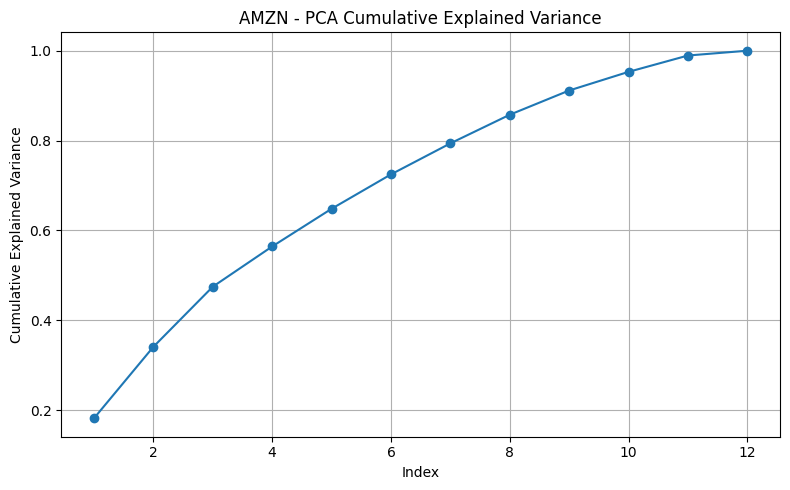

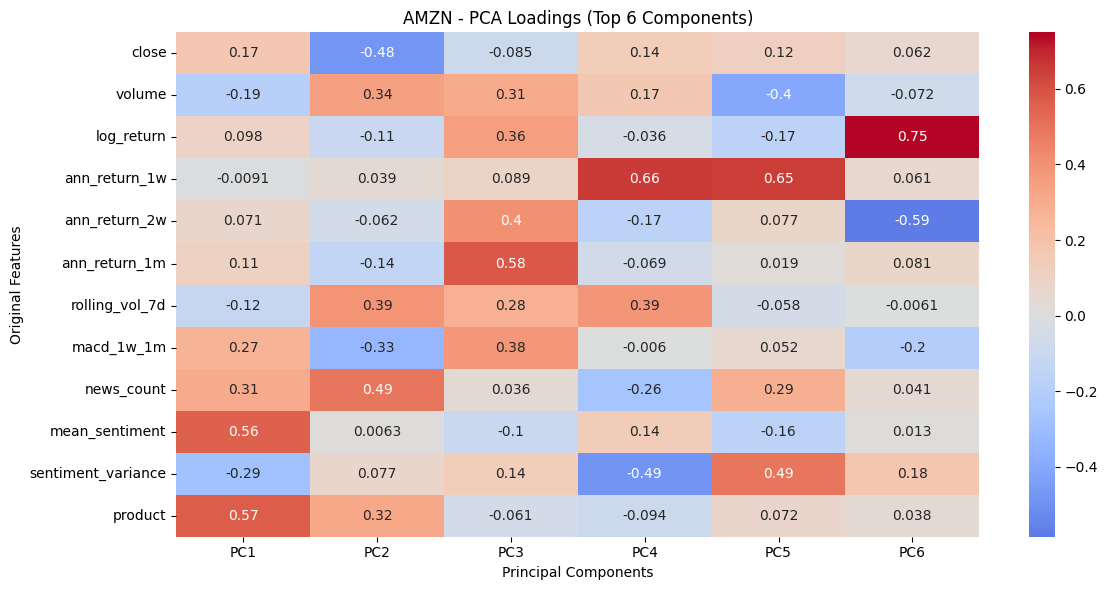

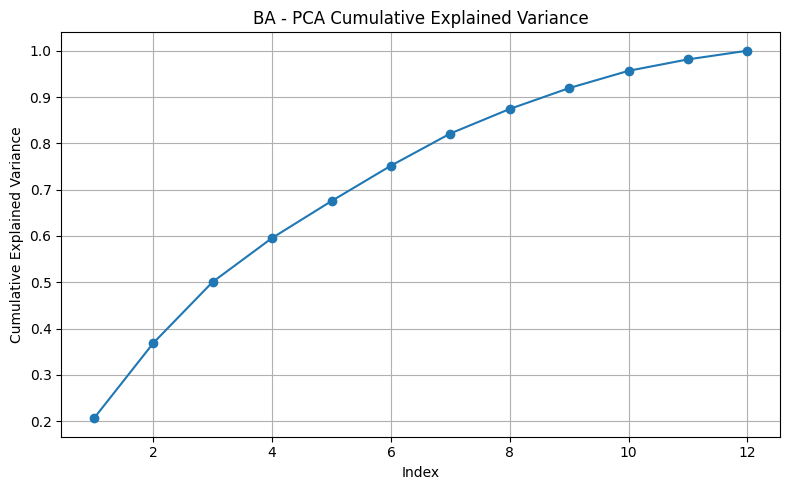

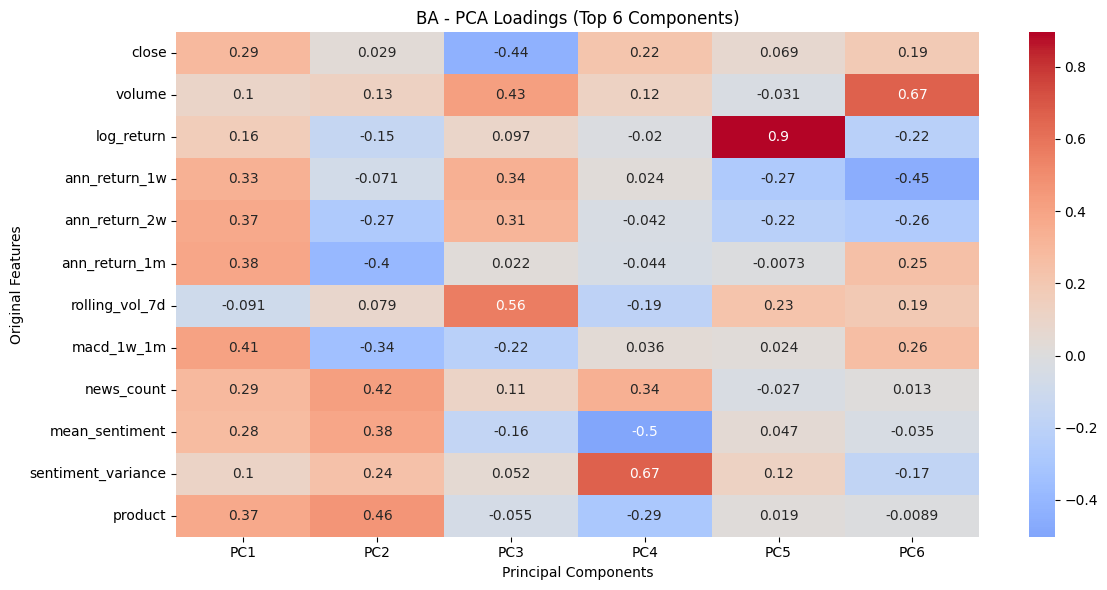

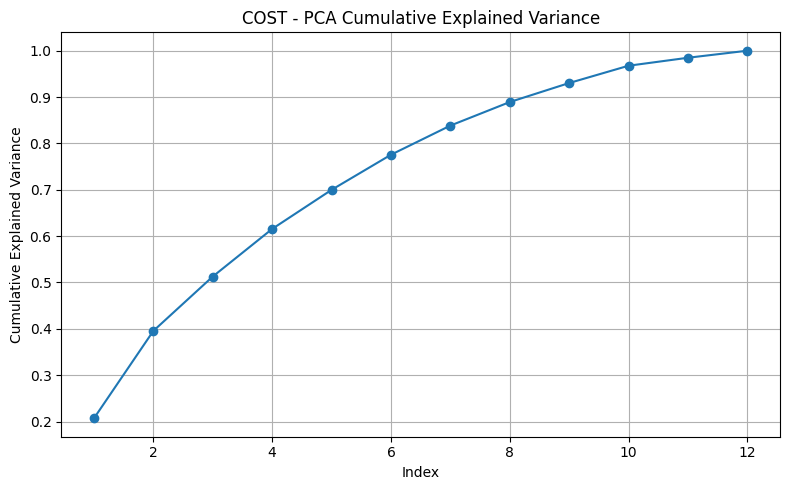

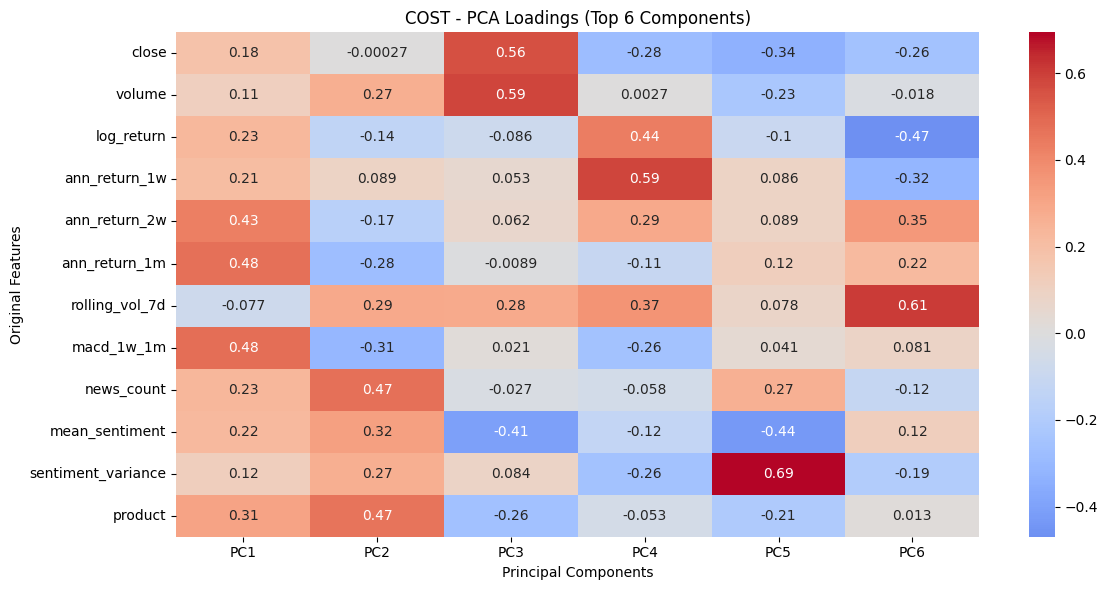

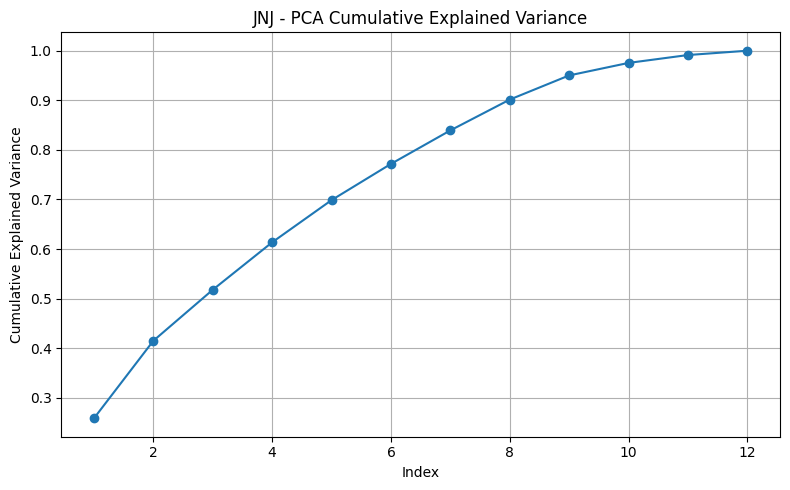

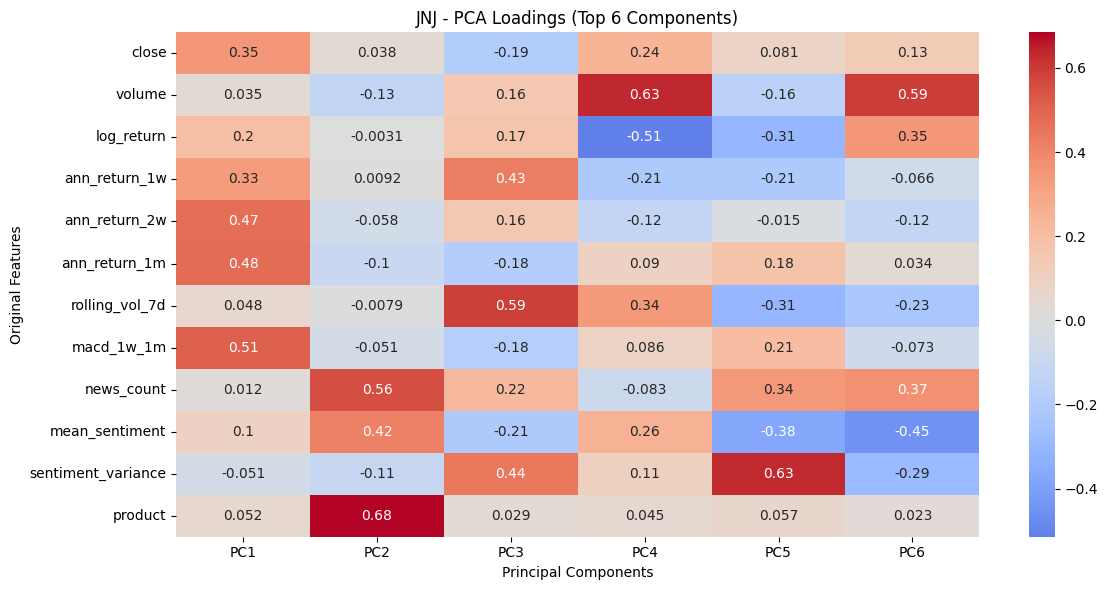

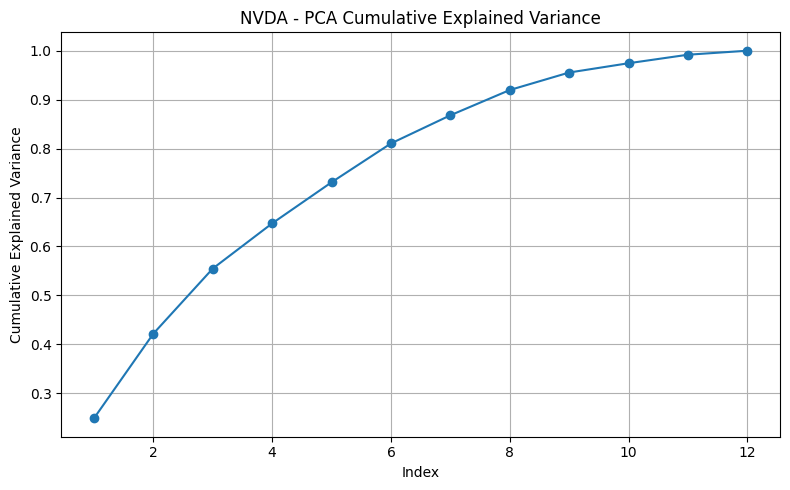

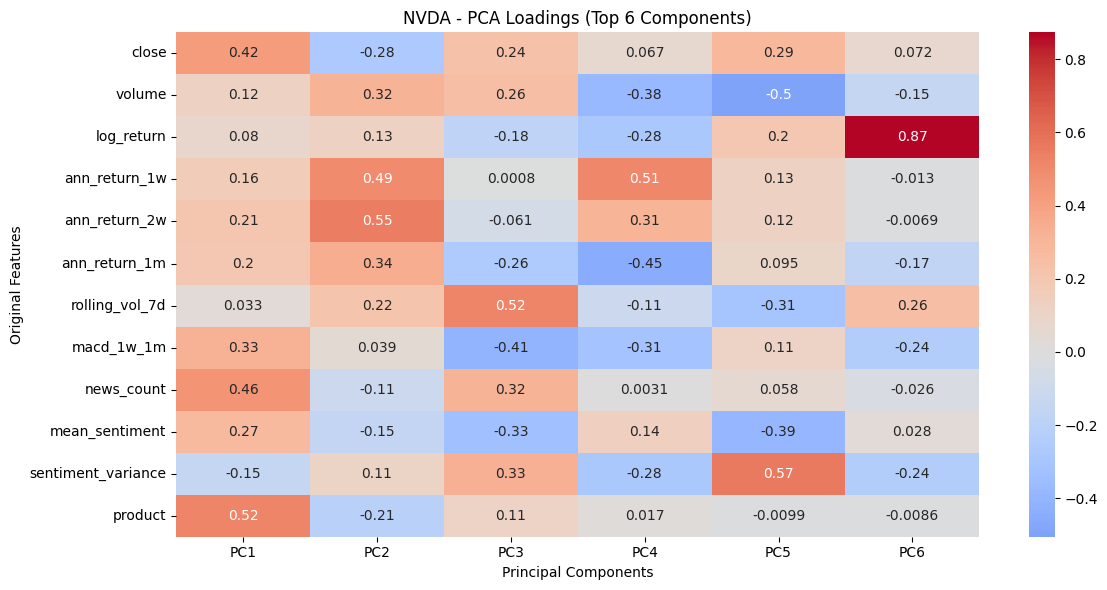

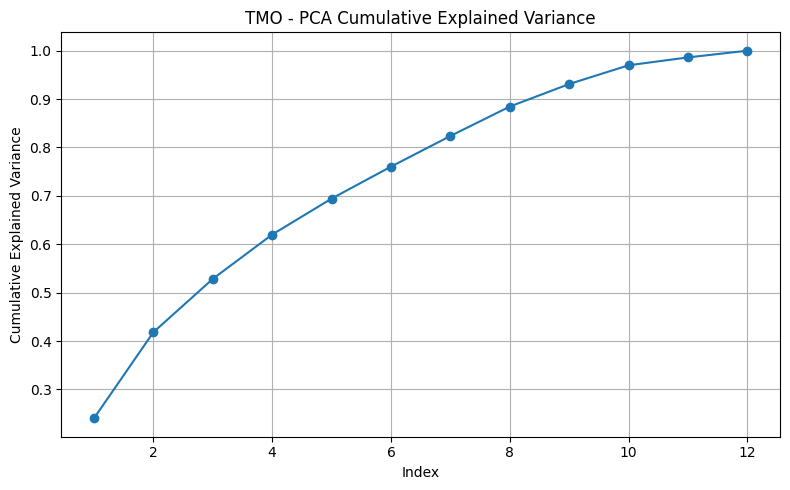

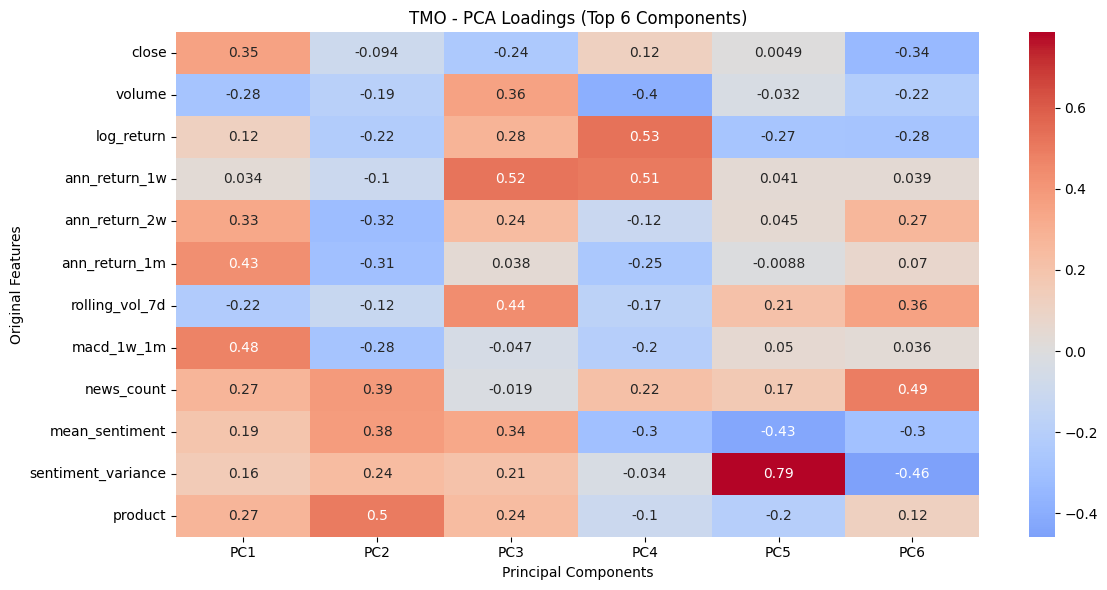

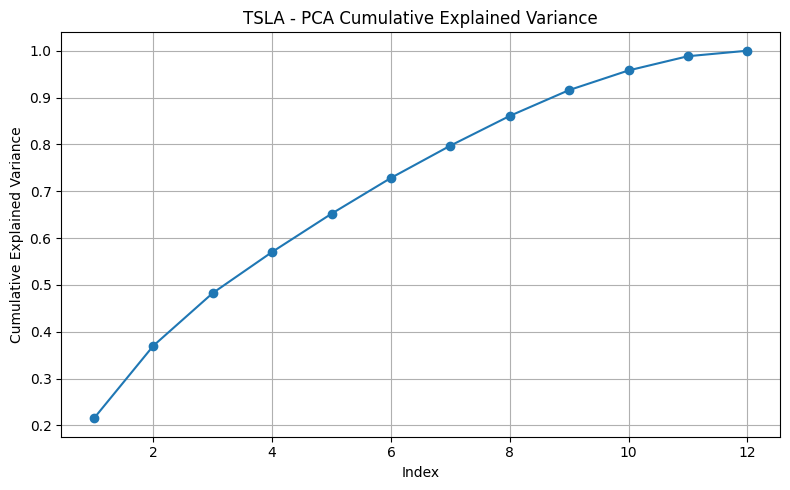

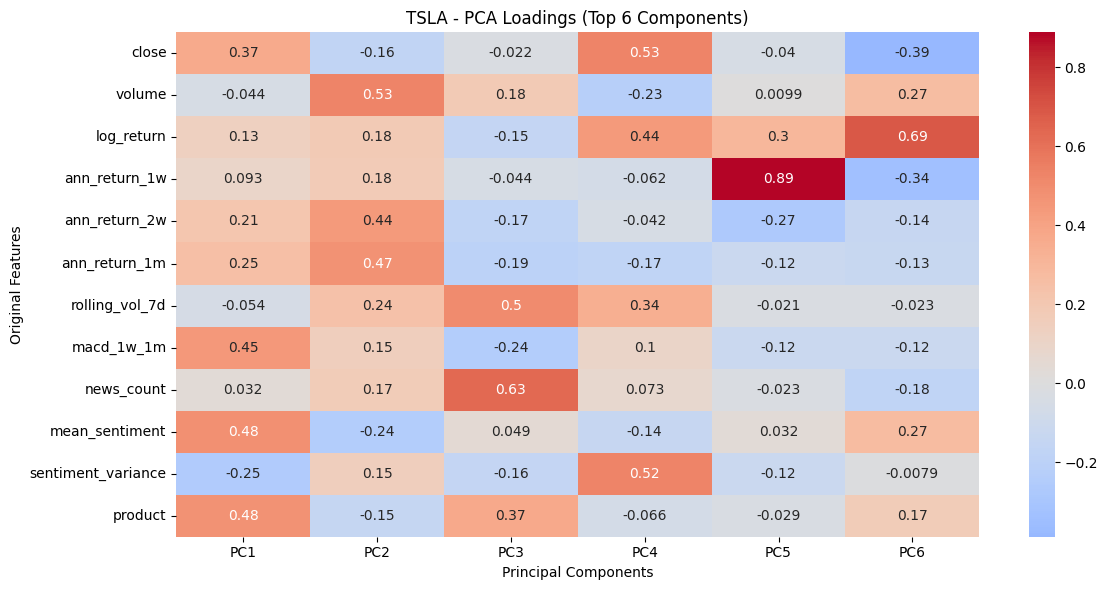

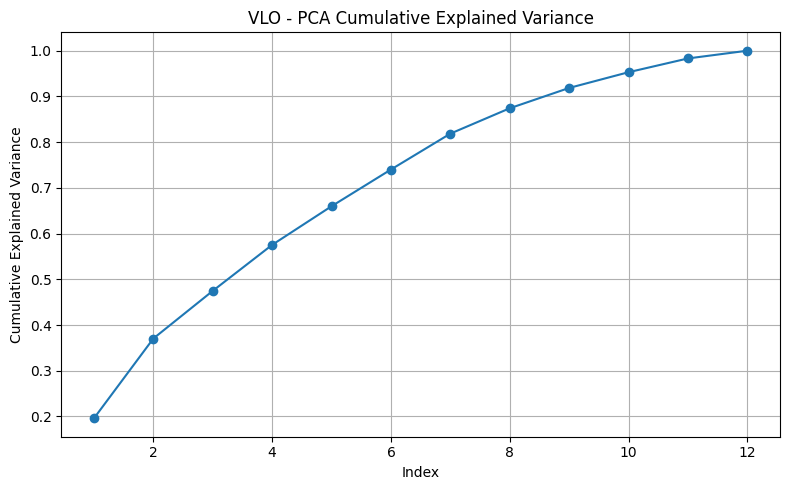

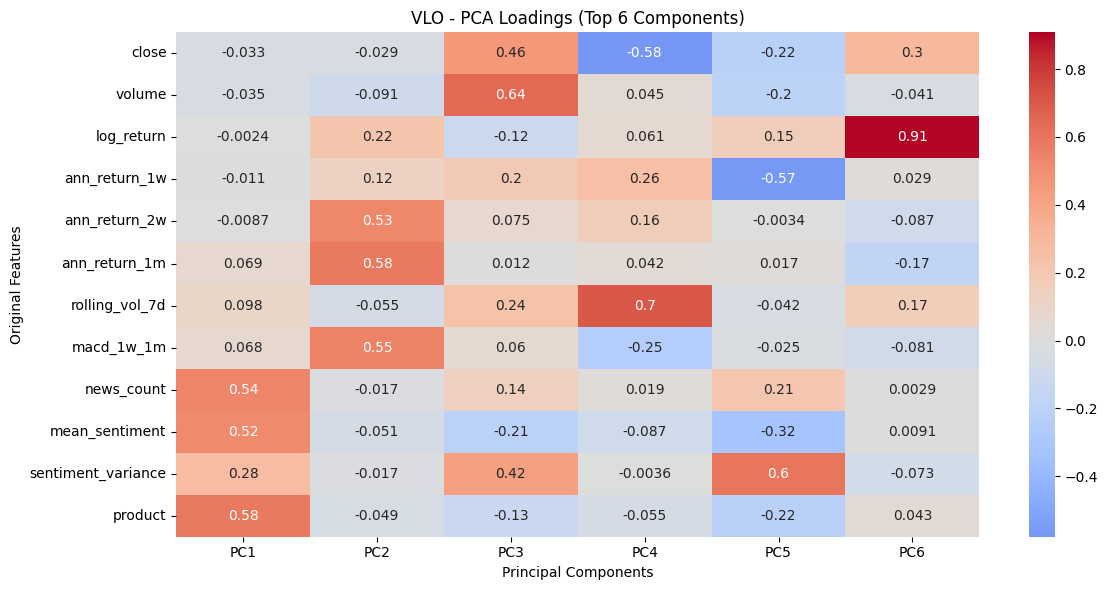

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ticker_to_pca = {}

for ticker in tickers:
    df = all_data[ticker].copy()
    # 1. Scale features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])  # (n_samples, n_features)

    # 2. PCA for cumulative variance plot
    pca_full = PCA()
    pca_full.fit(scaled_data)

    # 3. Plot cumulative explained variance
    cumulative_variance = pca_full.explained_variance_ratio_.cumsum()
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-')
    plt.xlabel("Index")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"{ticker} - PCA Cumulative Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{ticker}_pca_variance.png")
    plt.show()

    # 4. PCA with top 6 components
    pca = PCA(n_components=6)
    pca_result = pca.fit_transform(scaled_data)  # (n_samples, 6)

    # 5. Create DataFrame with date column
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(6)])
    pca_df['date'] = df['date'].values
    ticker_to_pca[ticker] = pca_df

    # 6. Plot loadings heatmap
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(6)],
        index=features
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
    plt.title(f"{ticker} - PCA Loadings (Top 6 Components)")
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    plt.tight_layout()
    plt.show()


In [162]:
pc_features = ['PC1', 'PC2', 'PC3', "PC4", "PC5", "PC6"]

In [163]:
scalers = {}
for stock in tickers:
    train_df = ticker_to_pca[stock][ticker_to_pca[stock]['date'].isin(train_dates)]
    scaler = StandardScaler()
    scaler.fit(train_df[pc_features])
    scalers[stock] = scaler
print("Scaler finished.")

Scaler finished.


# Build Dynamic Graph

In [164]:
# Load dynamic graph file
graph_df = pd.read_csv("graph_final.csv")
graph_df['date'] = pd.to_datetime(graph_df['date'])

tickers = ['AAPL', 'AMZN', 'BA', 'COST', 'JNJ', 'NVDA', 'TMO', 'TSLA', 'VLO']
edge_columns = graph_df.columns[1:]
stock_pairs = [col.split('&') for col in edge_columns]

# Build a dictionary mapping date → (edge_index, edge_attr)
date_to_graph = {}

for _, row in graph_df.iterrows():
    edge_index = []
    edge_attr = []
    for (stock1, stock2), col in zip(stock_pairs, edge_columns):
        if stock1 in tickers and stock2 in tickers:
            i = tickers.index(stock1)
            j = tickers.index(stock2)
            weight = float(row[col])
            if weight != 0:
                edge_index.append([i, j])
                edge_attr.append(weight)

    if edge_index:
        ei_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        ea_tensor = torch.tensor(edge_attr, dtype=torch.float32)
        date_str = row['date'].strftime('%Y-%m-%d')
        date_to_graph[date_str] = (ei_tensor, ea_tensor)  



# Define LSTM and GAT

In [165]:
# LSTM编码器
class StockLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, bidirectional=False)
    def forward(self, x):
        output, (h_n, _) = self.lstm(x)
        return output[:, -1, :]

# WeightedGATConv
class WeightedGATConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0, alpha=0.2):
        super().__init__()
        self.lin = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.leaky_relu = nn.LeakyReLU(alpha)
    def forward(self, x, edge_index, edge_weight):
        x = self.lin(x)
        x = self.dropout(x)
        num_nodes = x.size(0)
        agg = torch.zeros_like(x)
        for idx in range(edge_index.size(1)):
            src = edge_index[0, idx]
            tgt = edge_index[1, idx]
            agg[tgt] += edge_weight[idx] * x[src]
        return self.leaky_relu(agg + x)

class GATEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0, alpha=0.2):
        super().__init__()
        self.gat1 = WeightedGATConv(in_dim, hidden_dim, dropout, alpha)
        self.gat2 = WeightedGATConv(hidden_dim, out_dim, dropout, alpha)
    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        return x

# 包装全部部分，支持final_dropout
class PortfolioNet(nn.Module):
    def __init__(self, config, input_dim, tickers):
        super().__init__()
        self.lstm_encoder = StockLSTMEncoder(
            input_dim=input_dim,
            hidden_dim=config['lstm_hidden'],
            num_layers=config['lstm_layers'],
            dropout=config['lstm_dropout']
        )
        gat_input_dim = config['lstm_hidden'] * (2 if config['lstm_bidirectional'] else 1)
        self.gat_encoder = GATEncoder(
            in_dim=gat_input_dim,
            hidden_dim=config['gat_hidden'],
            out_dim=config['gat_hidden'],
            dropout=config['gat_dropout'],
            alpha=config['gat_alpha']
        )
        self.final_dropout = nn.Dropout(config.get('final_dropout', 0.2))
        self.final_layer = nn.Linear(config['gat_hidden'], 1)
        self.tickers = tickers

    def forward(self, seq_features, edge_index, edge_attr):
        # seq_features: [N_stocks, seq_len, feature_dim]
        x = self.lstm_encoder(seq_features)
        x = self.gat_encoder(x, edge_index, edge_attr)
        x = self.final_dropout(x)
        raw_scores = self.final_layer(x).squeeze(-1)
        weights = torch.tanh(raw_scores)
        norm_weights = weights / (weights.sum() + 1e-8)
        return norm_weights

In [166]:
def sharpe_ratio_loss(weights, returns, cov_matrix):
    """
    weights: 归一化后的portfolio权重，shape [N_stocks]
    returns: 对应股票下期真实收益，shape [N_stocks]
    cov_matrix: 对应股票历史协方差矩阵，shape [N_stocks, N_stocks]
    """
    expected_return = torch.dot(weights, returns)
    portfolio_var = weights.unsqueeze(0) @ cov_matrix @ weights.unsqueeze(1)
    portfolio_std = torch.sqrt(portfolio_var + 1e-8).squeeze()
    sharpe = expected_return / (portfolio_std + 1e-8)
    return -sharpe  # Adam优化器会自动最小化loss，负号表示最大化Sharpe


# Set Hyperparameters

In [167]:
best_config = {
    'batch_size': 32, 
    'lstm_hidden': 32, 
    'lstm_layers': 1, 
    'lstm_dropout': 0.211568785711302, 
    'lstm_bidirectional': False, 
    'gat_hidden': 32, 
    'gat_dropout': 0.2543779563655082, 
    'gat_alpha': 0.35342048467243786, 
    'lstm_weight_decay': 0.0001991365719619497, 
    'gat_weight_decay': 0.0005540009515614414, 
    'learning_rate': 0.0014116471096981293, 
    'final_dropout': 0.3368159821933386,
    'final_weight_decay': 0.0005000988611943706}

# Training Loop

In [176]:
epochs = 40
batch_size = best_config['batch_size']
seq_len = 30




model = PortfolioNet(best_config, input_dim=len(pc_features), tickers=tickers).to(device)
optimizer = torch.optim.Adam(
    [
        {'params': model.lstm_encoder.parameters(), 'weight_decay': best_config['lstm_weight_decay']},
        {'params': model.gat_encoder.parameters(), 'weight_decay': best_config['gat_weight_decay']},
        {'params': model.final_layer.parameters(), 'weight_decay': best_config.get('final_weight_decay', 0.0)}
    ],
    lr=best_config['learning_rate']
)

date2idx = {d: i for i, d in enumerate(dates)}
train_indices = [date2idx[d] for d in train_dates]

edge_index = None
edge_attr = None


for epoch in range(epochs):
    total_loss = 0.0
    train_points = train_indices[seq_len:-1]
    random.shuffle(train_points)
    num_batches = (len(train_points) + batch_size - 1) // batch_size

    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx in progress_bar:
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(train_points))
        batch_indices = train_points[start_idx:end_idx]
        stock_embeddings_batch = []
        future_returns_batch = []
        past_returns_batch = []

        for t in batch_indices:
            seq_batch = []
            future_returns = []
            skip_flag = False
            for stock in tickers:
                df = ticker_to_pca[stock]
                df_stock = all_data[stock]
                if t - seq_len < 0 or t + 1 >= len(df):
                    skip_flag = True
                    break
                seq = df[pc_features].iloc[t-seq_len:t]
                seq = scalers[stock].transform(seq)
                seq_batch.append(seq)
                future_returns.append(df_stock['log_return'].iloc[t+1])
            if skip_flag:
                continue
            stock_embeddings_batch.append(torch.tensor(seq_batch, dtype=torch.float32, device=device))
            future_returns_batch.append(torch.tensor(future_returns, dtype=torch.float32, device=device))
            window = min(20, t)
            past_returns = np.array([
                all_data[stock]['log_return'].iloc[t-window:t].values
                for stock in tickers
            ])
            past_returns_batch.append(torch.tensor(np.cov(past_returns) + 1e-6*np.eye(len(tickers)), dtype=torch.float32, device=device))

        if len(stock_embeddings_batch) == 0:
            continue

        x_t_batch = torch.stack(stock_embeddings_batch).to(device)
        future_returns_tensor = torch.stack(future_returns_batch).to(device)
        cov_matrices_tensor = torch.stack(past_returns_batch).to(device)

        batch_loss = 0.0
        for i in range(x_t_batch.shape[0]):
            t_idx = batch_indices[i]

            # update edge_index & edge_attr every 5 trading days or if uninitialized
            if (t_idx % 5 == 0) or (edge_index is None or edge_attr is None):
                current_date = dates[t_idx]
                graph_key = pd.to_datetime(current_date).strftime('%Y-%m-%d')
                if graph_key in date_to_graph: edge_index, edge_attr = date_to_graph[graph_key]
                else:
                    print(f"[Warning] Graph not found for {graph_key}, using full fallback.")
                    edge_list = [[m, n] for m in range(len(tickers)) for n in range(len(tickers)) if m != n]
                    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                    edge_attr = torch.ones(edge_index.shape[1], dtype=torch.float32)



            norm_weights = model(
                x_t_batch[i],
                edge_index.to(device),
                edge_attr.to(device)
            )

            loss = sharpe_ratio_loss(norm_weights, future_returns_tensor[i], cov_matrices_tensor[i])
            batch_loss += loss

        avg_batch_loss = batch_loss / x_t_batch.shape[0]
        optimizer.zero_grad()
        avg_batch_loss.backward()
        optimizer.step()
        total_loss += avg_batch_loss.item()
        progress_bar.set_postfix(loss=avg_batch_loss.item())

    avg_epoch_loss = total_loss / num_batches
    print(f"📉 Epoch {epoch+1} | Avg Loss: {avg_epoch_loss:.6f}")

print("✅ Training Finished")


Epoch 1/40: 100%|██████████| 46/46 [00:09<00:00,  4.80it/s, loss=0.0633] 


📉 Epoch 1 | Avg Loss: -0.065457


Epoch 2/40: 100%|██████████| 46/46 [00:09<00:00,  5.06it/s, loss=0.0683] 


📉 Epoch 2 | Avg Loss: -0.055801


Epoch 3/40: 100%|██████████| 46/46 [00:09<00:00,  5.10it/s, loss=-0.515] 


📉 Epoch 3 | Avg Loss: -0.064528


Epoch 4/40: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s, loss=0.074]  


📉 Epoch 4 | Avg Loss: -0.068467


Epoch 5/40: 100%|██████████| 46/46 [00:09<00:00,  5.08it/s, loss=-0.253] 


📉 Epoch 5 | Avg Loss: -0.059358


Epoch 6/40: 100%|██████████| 46/46 [00:09<00:00,  5.11it/s, loss=-0.441]  


📉 Epoch 6 | Avg Loss: -0.060969


Epoch 7/40: 100%|██████████| 46/46 [00:09<00:00,  5.08it/s, loss=0.237]   


📉 Epoch 7 | Avg Loss: -0.049212


Epoch 8/40: 100%|██████████| 46/46 [00:09<00:00,  5.03it/s, loss=-0.443] 


📉 Epoch 8 | Avg Loss: -0.055162


Epoch 9/40: 100%|██████████| 46/46 [00:09<00:00,  5.11it/s, loss=-0.485] 


📉 Epoch 9 | Avg Loss: -0.044931


Epoch 10/40: 100%|██████████| 46/46 [00:09<00:00,  4.77it/s, loss=-0.318]  


📉 Epoch 10 | Avg Loss: -0.070434


Epoch 11/40: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s, loss=0.802]  


📉 Epoch 11 | Avg Loss: -0.054477


Epoch 12/40: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s, loss=0.472]  


📉 Epoch 12 | Avg Loss: -0.051138


Epoch 13/40: 100%|██████████| 46/46 [00:09<00:00,  5.05it/s, loss=0.642]   


📉 Epoch 13 | Avg Loss: -0.061455


Epoch 14/40: 100%|██████████| 46/46 [00:09<00:00,  4.98it/s, loss=0.308]  


📉 Epoch 14 | Avg Loss: -0.051940


Epoch 15/40: 100%|██████████| 46/46 [00:09<00:00,  4.96it/s, loss=-0.19]   


📉 Epoch 15 | Avg Loss: -0.054166


Epoch 16/40: 100%|██████████| 46/46 [00:09<00:00,  5.02it/s, loss=0.247]   


📉 Epoch 16 | Avg Loss: -0.063373


Epoch 17/40: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s, loss=-0.269]  


📉 Epoch 17 | Avg Loss: -0.058069


Epoch 18/40: 100%|██████████| 46/46 [00:09<00:00,  5.03it/s, loss=0.448]  


📉 Epoch 18 | Avg Loss: -0.040209


Epoch 19/40: 100%|██████████| 46/46 [00:09<00:00,  5.06it/s, loss=-0.177]  


📉 Epoch 19 | Avg Loss: -0.068202


Epoch 20/40: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s, loss=0.151]  


📉 Epoch 20 | Avg Loss: -0.065656


Epoch 21/40: 100%|██████████| 46/46 [00:09<00:00,  5.02it/s, loss=-0.1]   


📉 Epoch 21 | Avg Loss: -0.058172


Epoch 22/40: 100%|██████████| 46/46 [00:09<00:00,  5.05it/s, loss=-0.114]  


📉 Epoch 22 | Avg Loss: -0.062711


Epoch 23/40: 100%|██████████| 46/46 [00:09<00:00,  5.03it/s, loss=-0.321] 


📉 Epoch 23 | Avg Loss: -0.059170


Epoch 24/40: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s, loss=-0.206] 


📉 Epoch 24 | Avg Loss: -0.067863


Epoch 25/40: 100%|██████████| 46/46 [00:09<00:00,  5.09it/s, loss=0.445]  


📉 Epoch 25 | Avg Loss: -0.054412


Epoch 26/40: 100%|██████████| 46/46 [00:09<00:00,  5.07it/s, loss=-0.362]  


📉 Epoch 26 | Avg Loss: -0.066971


Epoch 27/40: 100%|██████████| 46/46 [00:09<00:00,  5.03it/s, loss=-0.122]   


📉 Epoch 27 | Avg Loss: -0.063272


Epoch 28/40: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s, loss=-0.232] 


📉 Epoch 28 | Avg Loss: -0.058967


Epoch 29/40: 100%|██████████| 46/46 [00:09<00:00,  5.06it/s, loss=-0.0978]


📉 Epoch 29 | Avg Loss: -0.066371


Epoch 30/40: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s, loss=0.76]    


📉 Epoch 30 | Avg Loss: -0.056872


Epoch 31/40: 100%|██████████| 46/46 [00:09<00:00,  5.06it/s, loss=0.683]  


📉 Epoch 31 | Avg Loss: -0.054787


Epoch 32/40: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s, loss=-0.405]   


📉 Epoch 32 | Avg Loss: -0.061587


Epoch 33/40: 100%|██████████| 46/46 [00:09<00:00,  5.07it/s, loss=-0.105] 


📉 Epoch 33 | Avg Loss: -0.065808


Epoch 34/40: 100%|██████████| 46/46 [00:09<00:00,  4.90it/s, loss=-0.187] 


📉 Epoch 34 | Avg Loss: -0.067090


Epoch 35/40: 100%|██████████| 46/46 [00:09<00:00,  5.03it/s, loss=-0.0743] 


📉 Epoch 35 | Avg Loss: -0.058311


Epoch 36/40: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s, loss=-0.881] 


📉 Epoch 36 | Avg Loss: -0.062354


Epoch 37/40: 100%|██████████| 46/46 [00:09<00:00,  4.94it/s, loss=0.0541] 


📉 Epoch 37 | Avg Loss: -0.068409


Epoch 38/40: 100%|██████████| 46/46 [00:09<00:00,  5.06it/s, loss=-0.0553]


📉 Epoch 38 | Avg Loss: -0.058979


Epoch 39/40: 100%|██████████| 46/46 [00:09<00:00,  5.01it/s, loss=-0.126] 


📉 Epoch 39 | Avg Loss: -0.067697


Epoch 40/40: 100%|██████████| 46/46 [00:09<00:00,  4.89it/s, loss=0.157]   

📉 Epoch 40 | Avg Loss: -0.063401
✅ Training Finished


In [177]:
torch.save(model.state_dict(), "best_portfolio_model.pth")
model.load_state_dict(torch.load("best_portfolio_model.pth"))
model.eval()
print("✅ Model is saved and reload.")

✅ Model is saved and reload.


# Start Testing

In [178]:
test_indices = [date2idx[d] for d in test_dates]
test_points = test_indices[seq_len:-1]

weights_all_days = []
test_dates_list = []

num_batches = len(test_points) // batch_size
if len(test_points) % batch_size != 0:
    num_batches += 1

for batch_idx in tqdm(range(num_batches), desc="Predicting (test set)"):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(test_points))
    batch_indices = test_points[start_idx:end_idx]

    stock_embeddings_batch = []

    for t in batch_indices:
        seq_batch = []
        skip_flag = False
        for stock in tickers:
            df = ticker_to_pca[stock]
            if t - seq_len < 0 or t + 1 >= len(df):
                skip_flag = True
                break
            seq = df[pc_features].iloc[t-seq_len:t]
            seq = scalers[stock].transform(seq)
            seq_batch.append(seq)
        if skip_flag: continue
        stock_embeddings_batch.append(torch.tensor(seq_batch, dtype=torch.float32, device=device))
        test_dates_list.append(dates[t])


    if len(stock_embeddings_batch) == 0: continue
    x_t_batch = torch.stack(stock_embeddings_batch).to(device)
    for i in range(x_t_batch.shape[0]):
        x_t = x_t_batch[i] # shape: [N_stocks, seq_len, feature_dim]
        with torch.no_grad():
            norm_weights = model(
                x_t,
                edge_index.to(device),
                edge_attr.to(device)
            )
        weights_all_days.append(norm_weights.cpu().numpy())

weights_df = pd.DataFrame(weights_all_days, columns=tickers)
weights_df['date'] = test_dates_list
weights_df.to_csv("predicted_weights.csv", index=False)
print("✅ Testing set weight saved to: predicted_weights.csv")


Predicting (test set):   0%|          | 0/19 [00:00<?, ?it/s]

Predicting (test set): 100%|██████████| 19/19 [00:01<00:00,  9.76it/s]

✅ Testing set weight saved to: predicted_weights.csv


# Result

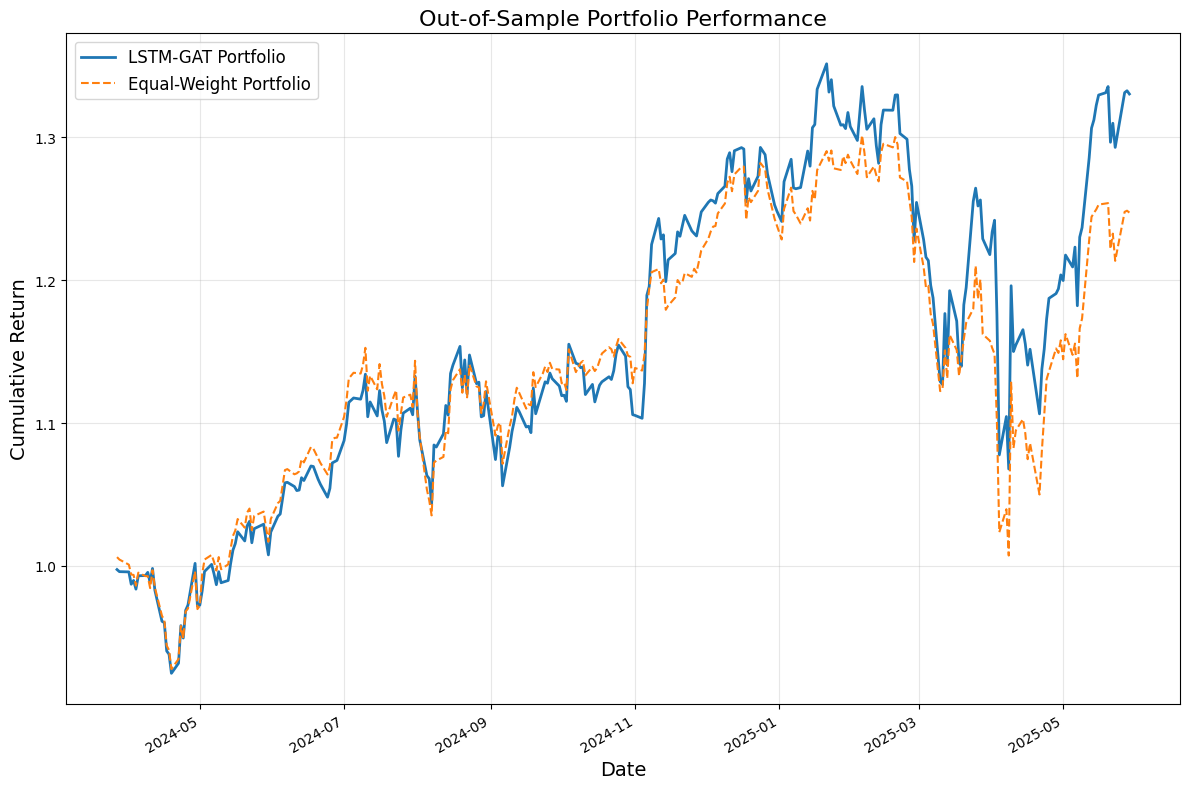

In [181]:
test_price_data = pd.DataFrame({'date': test_dates_list})
for stock in tickers:
    prices = []
    for d in test_dates_list:
        idx = date2idx[d]
        prices.append(all_data[stock].iloc[idx]['close'])
    test_price_data[stock] = prices


returns = test_price_data[tickers].pct_change().dropna().reset_index(drop=True)
weights = weights_df[tickers].iloc[:-1].reset_index(drop=True)


portfolio_returns = (returns.values * weights.values).sum(axis=1)
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_returns = (returns.values * equal_weights).sum(axis=1)


cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_equal = (1 + equal_returns).cumprod()


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plot_dates = pd.to_datetime(test_price_data['date'].iloc[1:])

plt.figure(figsize=(12, 8))
plt.plot(plot_dates, cumulative_portfolio, label='LSTM-GAT Portfolio', linewidth=2)
plt.plot(plot_dates, cumulative_equal, label='Equal-Weight Portfolio', linestyle='--')
plt.title('Out-of-Sample Portfolio Performance', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('out_of_sample_performance.png', dpi=300)
plt.show()


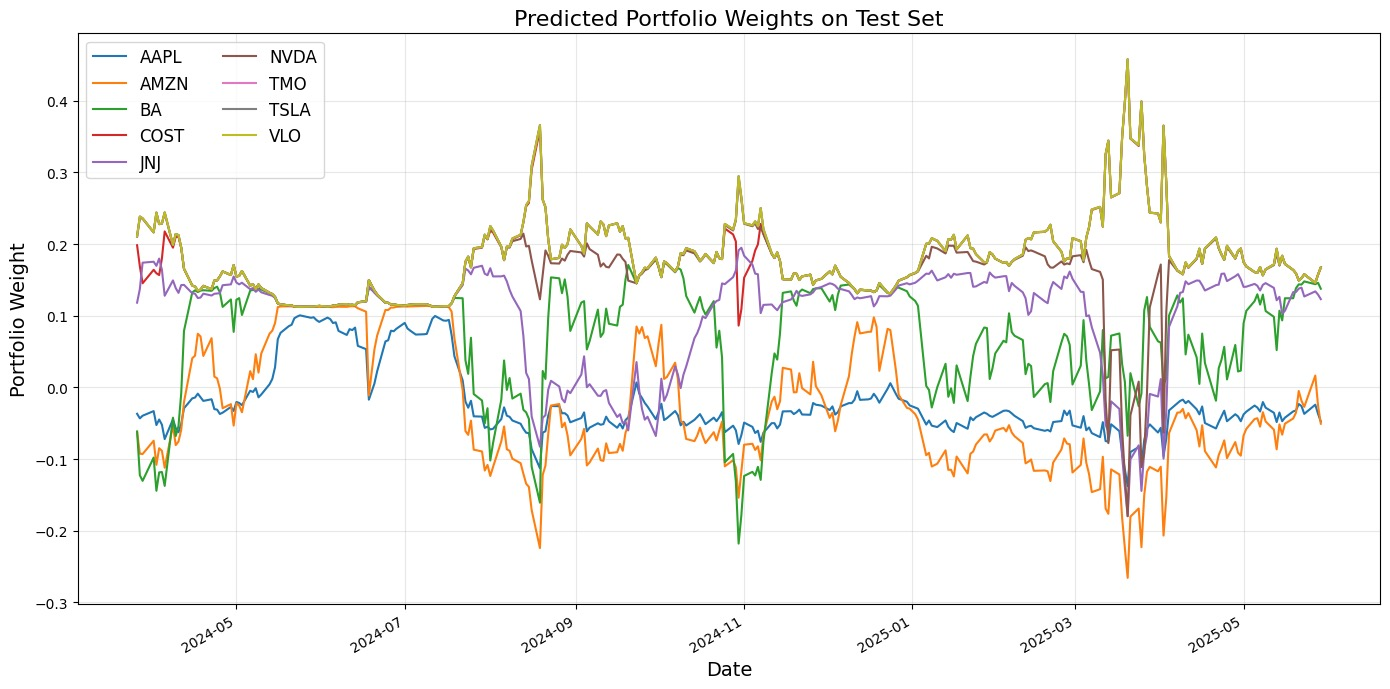

In [187]:
weights_df['date'] = pd.to_datetime(weights_df['date'])


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(14, 7))

# Plot each stock's weights
for stock in tickers:
    plt.plot(weights_df['date'], weights_df[stock], label=stock)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Weight', fontsize=14)
plt.title('Predicted Portfolio Weights on Test Set', fontsize=16)
plt.legend(fontsize=12, ncol=2)
plt.grid(True, alpha=0.3)

# Make dates readable
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Evaluation Metrics

In [182]:
def calculate_metrics(returns, var_conf_level=0.95):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    
    # Historical Value at Risk (e.g., 5% worst return)
    var_percentile = 100 * (1 - var_conf_level)
    value_at_risk = np.percentile(returns, var_percentile)

    return total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, value_at_risk


In [183]:
# Calculate metrics
port_metrics = calculate_metrics(portfolio_returns)

# Unpack results
total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, value_at_risk = port_metrics

# Print results nicely
print("\n📊 Portfolio Performance Metrics:")
print(f"Total Return:        {total_return:.2%}")
print(f"Annualized Return:   {annualized_return:.2%}")
print(f"Volatility:          {volatility:.2%}")
print(f"Sharpe Ratio:        {sharpe_ratio:.4f}")
print(f"Max Drawdown:        {max_drawdown:.2%}")
print(f"Value at Risk (5%):  {value_at_risk:.2%}")



📊 Portfolio Performance Metrics:
Total Return:        33.04%
Annualized Return:   27.72%
Volatility:          28.45%
Sharpe Ratio:        0.9745
Max Drawdown:        -20.99%
Value at Risk (5%):  -2.64%
